<a href="https://colab.research.google.com/github/SamShelby/Deep_Learning/blob/master/src/tareas/t2/notebooks/ej2_ufc11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2: redes convolucionales, recurrentes y transferencia
## Ejercicio 2

Curso: [Aprendizaje Profundo](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_profundo/). Profesor: [Gibran Fuentes Pineda](http://turing.iimas.unam.mx/~gibranfp/). Ayudantes: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/).
Alumno: [Samuel López](https://github.com/SamShelby)
---
---

## 0 Preparación
### 0.1 Bibliotecas

In [37]:
import os
# funciones aleatorias
import random
# descomprimir
import tarfile
# sistema de archivos
from os.path import join

# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
# almacenamiento de arreglos multidimensionales
import zarr
# redes
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split
# inspección de arquitectura
from torchinfo import summary
from itertools import islice as take

from tqdm import tqdm

### 0.2 Auxiliares
Función para graficar el histórico del entrenamiento.

In [38]:
def history_plot(history, features=['trn_loss_hist', 'tst_loss_hist']):
    fig, ax = plt.subplots(figsize=(8, 6))
    for feature in features:
        ax.plot(history[feature], label=feature)

    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.legend()
    plt.title('Loss History')
    plt.show()

Funciones de entrenamiento de modelos de redes neuronales de clasificación con pytorch.

In [39]:
def train_epoch(dl, model, opt, device):
    # modelo en modo de entrenamiento
    model.train()

    # entrenamiento de una época
    for x, y_true in dl:
        x = x.to(device)
        y_true = y_true.to(device)
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()


def eval_epoch(dl, model, device, num_batches=None):
    # desactivamos temporalmente la gráfica de cómputo
    with torch.no_grad():
        # modelo en modo de evaluación
        model.eval()

        losses, accs = [], []
        # validación de la época
        for x, y_true in dl:
            x = x.to(device)
            y_true = y_true.to(device)
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)

            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)

        return loss, acc


# ### 4.1 Ciclo de entrenamiento

def train_model(trn_dl, tst_dl, model, epochs=10):
    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-3)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)

    loss_hist, acc_hist = [], []
    # ciclo de entrenamiento
    for epoch in tqdm(range(epochs)):
        train_epoch(trn_dl, model, opt, device)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device)

        # evaluamos la época en validación
        val_loss, val_acc = eval_epoch(tst_dl, model, device)

        loss_hist.append([trn_loss, val_loss])
        acc_hist.append([trn_acc, val_acc])

    loss_hist = np.array(loss_hist)
    acc_hist = np.array(acc_hist)

    return {'trn_loss_hist': loss_hist[:, 0],
            'tst_loss_hist': loss_hist[:, 1],
            'trn_acc_hist': acc_hist[:, 0],
            'tst_acc_hist': acc_hist[:, 1]}

Constantes para los modelos y el entrenamiento.

In [40]:
# directorio de datos
DATA_DIR = os.path.join('..', 'data')

# tamaño del lote
BATCH_SIZE = 32
# tamaño del vector de características
FEAT_SIZE = 1024

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)

## 1 Implementando la tubería de datos para la tarea objetivo.

### 1.1 Conjunto de datos
Clase UCF11 para descarga los archivos y descomprimirlos.

In [41]:
class UCF11:

    def __init__(self, root, download=False):
        self.root = root
        self.zarr_dir = join(root, 'ucf11.zarr')
        if download:
            self.download()
        self.z = zarr.open(self.zarr_dir, 'r')
        self.paths = list(self.z.array_keys())

    def __getitem__(self, i):
        arr = self.z[self.paths[i]]
        x = np.array(arr)
        y = np.array(arr.attrs['y'], dtype=np.int64)
        return x, y

    def __len__(self):
        return len(self.paths)

    def _check_integrity(self):
        return os.path.isdir(self.zarr_dir)

    def _extract(self, root, filename):
        tar = tarfile.open(join(root, filename), "r:gz")
        tar.extractall(root)
        tar.close()

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_url(
            url='https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7/download',
            root=self.root,
            filename='ucf11.zarr.tar.gz',
            md5='c8a82454f9ec092d00bcd99c849e03fd'
        )
        self._extract(self.root, 'ucf11.zarr.tar.gz')

Creamos los datasets de entrenamiento (80%) y prueba (20%) y visualizmos un elemento del
entrenamiento de prueba. Cada elemento del dataset tiene una dimensión de (10, 1024).
La etiquetas son representadas por enteros del 0-10.

In [42]:
ds = UCF11(join(DATA_DIR, 'ucf11'), True)
x, y = ds[0]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'x [0][:5]={x[0][:5]}')
print(f'y shape={y.shape} dtype={y.dtype} {y}')
print(f'y {y}')

trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
print('Muestras en entrenamiento y prueba: {}, {}'.format(len(trn_ds), len(tst_ds)))

Files already downloaded and verified
x shape=(10, 1024) dtype=float32
x [0][:5]=[0.00022111 0.00368518 0.00314753 0.00201778 0.09296297]
y shape=() dtype=int64 0
y 0
Muestras en entrenamiento y prueba: 1279, 320


### 2.4 Cargadores de datos

Los [cargadores de datos](https://pytorch.org/docs/1.6.0/data.html) pueden precargar el siguiente lote de de entrenamiento forma paralela si especificamos `num_workers => 2`.

<img src="https://github.com/gibranfp/CursoAprendizajeProfundo/raw/2022-1/figs/data-loading1.png" />
<img src="https://github.com/gibranfp/CursoAprendizajeProfundo/raw/2022-1/figs/data-loading2.png" />
<br>
Fuente: tensorflow.org

<br>
Se muestra el tamaño de un batch de entrenamiento.

In [43]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=0
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=0
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


Se implementa un modelo RNN con una capa GRU bidireccional con un total de ~890k parámetros entrenables.

In [44]:
class RNN(nn.Module):

    def __init__(self, input_size=1024, hidden_size=128, num_classes=11, bidirectional=True):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=1, batch_first=True, bidirectional=True)
        self.cls = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)

    def forward(self, x):
        # Batch, Seq, Feats, Hidden
        # [B, S, F] => [B, F, S]
        x = x.movedim(1, 2)
        # [B, F, S]
        x = self.bn(x)
        # [B, F, S] => [B, S, F]
        x = x.movedim(1, 2)
        # [B, S, F] => [B, S, H]
        x, _ = self.rnn(x)
        # [B, S, H] => [B, H]
        # toma el último paso, participación 1
        x = x[:, -1, :]
        # [B, H] = [B, 11]
        x = self.cls(x)
        return x

In [45]:
model = RNN().eval()
out = model(torch.zeros(1, 10, 1024))
print(out.shape)

# %% ### 3.2 Inspección de arquitectura
print(summary(model, (1, 10, 1024), device='cpu', verbose=0))


torch.Size([1, 11])
Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      --                        --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 256]              886,272
├─Linear: 1-3                            [1, 11]                   2,827
Total params: 891,147
Trainable params: 891,147
Non-trainable params: 0
Total mult-adds (M): 8.87
Input size (MB): 0.04
Forward/backward pass size (MB): 0.10
Params size (MB): 3.56
Estimated Total Size (MB): 3.71


Entrenamos el modelo durante 30 epocas

In [46]:
## 4 Entrenamiento
model = RNN(bidirectional=True)
history_rnn = train_model(trn_dl, tst_dl, model, epochs=30)

100%|██████████| 30/30 [00:51<00:00,  1.71s/it]


Graficamos el progreso en el entrenamiento del modelo.
Podemos observar como después de la 5ta época, el modelo comienza a sobreajustarse a los datos de entrenamiento.
En la gráfica de la exactitud, podemos observar como se logra tener un 60% de exactitud en la clasificación
del dataset de prueba.

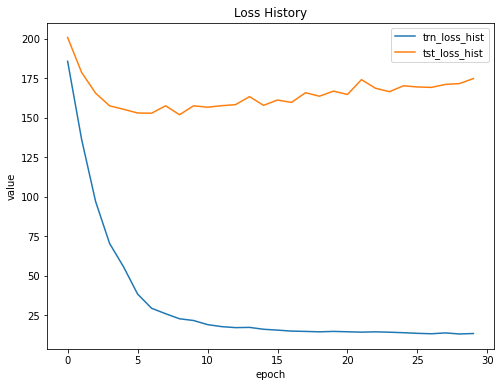

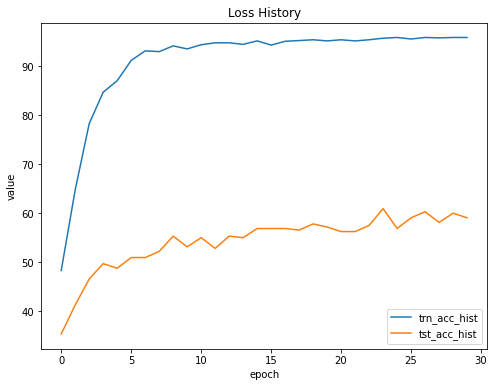

In [47]:
history_plot(history_rnn, features=['trn_loss_hist', 'tst_loss_hist'])
history_plot(history_rnn, features=['trn_acc_hist', 'tst_acc_hist'])

Usamos ahora un modelo con una capa convolucional. Se escogieron 280 canales de salida de la capa convolucional para tener 795k parámetros que es similar
al número de parámetros del modelo RNN (~890k). <br>
La convolución se está realizando sobre la dimensión de secuencias (i.e. dim=10).

In [50]:
class CNN(nn.Module):

    def __init__(self, input_size=1024, channels=10, kernel=3, hidden_size=128, num_classes=11):
        super().__init__()

        self.bn = nn.BatchNorm1d(input_size)
        self.cnn = nn.Conv1d(in_channels=input_size,
                             out_channels=hidden_size,
                             kernel_size=kernel,
                             padding='same')

        self.dropout = nn.Dropout(p=0.3)

        self.cls = nn.Linear(hidden_size * channels, num_classes)

    def forward(self, x):
        # Batch, Seq, Feats, Hidden
        # [B, S, F] => [B, F, S]
        x = x.movedim(1, 2)
        # [B, F, S]
        # x = self.bn(x)
        # [B, F, S] => [B, S, F]
        # x = x.movedim(1, 2)
        # [B, S, F] => [B, S, H]
        x = self.cnn(x)

        x = self.dropout(x)
        # [B, S, H] => [B, H]
        x = torch.flatten(x, start_dim=1, end_dim=2)
        x = self.cls(x)
        return x

model = CNN(hidden_size=280).eval()
out = model(torch.zeros(1, 10, 1024))
print(out.shape)
print(summary(model, (1, 10, 1024), device='cpu', verbose=0))

torch.Size([1, 11])
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Conv1d: 1-1                            [1, 280, 10]              860,440
├─Dropout: 1-2                           [1, 280, 10]              --
├─Linear: 1-3                            [1, 11]                   30,811
Total params: 891,251
Trainable params: 891,251
Non-trainable params: 0
Total mult-adds (M): 8.64
Input size (MB): 0.04
Forward/backward pass size (MB): 0.02
Params size (MB): 3.57
Estimated Total Size (MB): 3.63


Se realiza el entrenamiento del modelo con 1 capa convolucional durante 30 épocas.

In [51]:
model = CNN(hidden_size=280)
history_cnn = train_model(trn_dl, tst_dl, model, epochs=30)

100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Graficamos los datos históricos durante el entrenamiento. <br>
La exactitud en la clasificación en los datos de prueba se queda abajo del 50%.

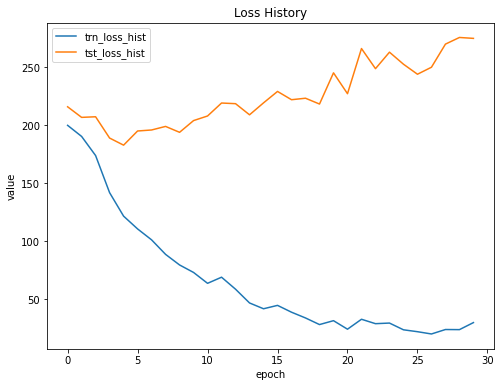

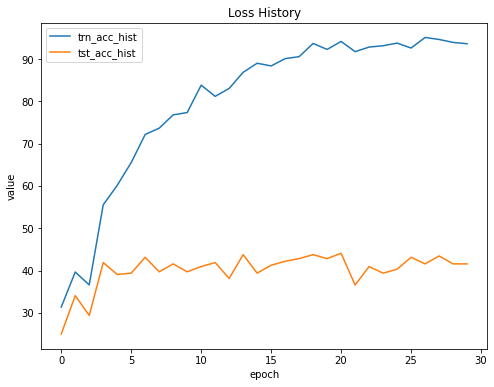

In [52]:
history_plot(history_cnn, features=['trn_loss_hist', 'tst_loss_hist'])
history_plot(history_cnn, features=['trn_acc_hist', 'tst_acc_hist'])

Por último compararemos el entrenamiento del modelo RNN y CNN.

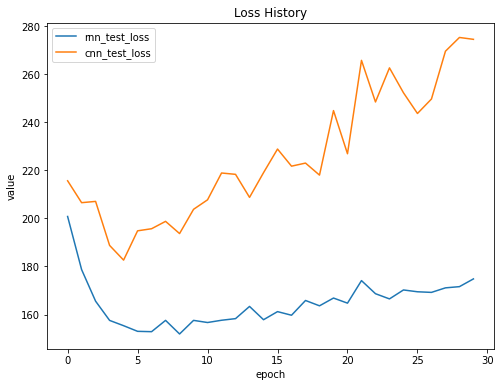

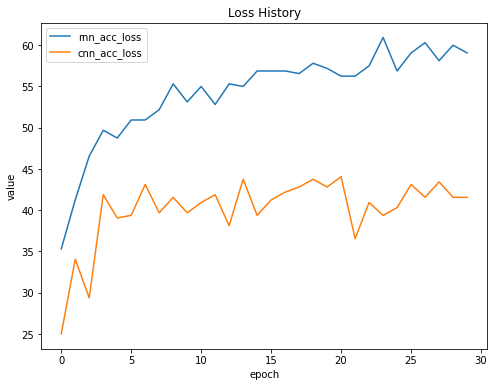

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history_rnn['tst_loss_hist'], label='rnn_test_loss')
ax.plot(history_cnn['tst_loss_hist'], label='cnn_test_loss')

plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.title('Loss History')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history_rnn['tst_acc_hist'], label='rnn_acc_loss')
ax.plot(history_cnn['tst_acc_hist'], label='cnn_acc_loss')

plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.title('Loss History')
plt.show()


Vemos en las gráficas de la pérdida y de exactitud, el modelo RNN es superior al CNN. Esto se debe a que la red recurrente
es capaz de extraer las relaciones entre características de forma secuencial. 

